In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

from keras.datasets import cifar10

from kerasutils import hits_and_misses, describe_model
from imageutils import block_dct
from imageutils import dataset_transform_block_dct

import matplotlib.pyplot as plt
import numpy as np

import random

/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(trainX_orig, trainY_orig), (testX, testY) = cifar10.load_data()

In [3]:
# Have to decimate training set size due to memory constraints?
(trainX, testX_dummy, trainY, testY_dummy) = train_test_split(trainX_orig, trainY_orig, test_size=0.25)

In [4]:
trainX = trainX / 255.0
testX = testX / 255.0
print(trainX.shape)
print(testX.shape)
print(trainX.dtype)

(37500, 32, 32, 3)
(10000, 32, 32, 3)
float64


In [5]:
trainX = dataset_transform_block_dct(trainX,8,4)
testX = dataset_transform_block_dct(testX,8,4)
print(trainX.shape)
print(testX.shape)

(37500, 56, 56, 3)
(10000, 56, 56, 3)


In [6]:
# Transform labels from int to one-hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

print(trainY.shape)
print(testY.shape)
n_classes = trainY.shape[1]
height = trainX.shape[1]
width = trainX.shape[2]
channels = trainX.shape[3]

print(height, width, channels)

(37500, 10)
(10000, 10)
56 56 3


In [9]:
# "Transform" CNN architecture with Keras
regularizer = regularizers.l2(0.003)

model = Sequential()
model.add(Conv2D(input_shape=(height,width,channels), filters=64,  
                 use_bias=True, kernel_size=(8,8), strides=8,
                 kernel_regularizer=regularizer))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.1))
#model.add(Conv2D(filters=192,use_bias=True, kernel_size=(3,3)))
#model.add(Activation('relu'))
#model.add(Dropout(0.4))
model.add(Conv2D(filters=192,use_bias=True, kernel_size=(3,3),
                 kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(0.3))
#model.add(Dense(128))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(128))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(lb.classes_.shape[0], activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# Deeper architecture
# https://arxiv.org/pdf/1412.6806.pdf
model = Sequential()
model.add(Conv2D(input_shape=(height,width,channels), filters=64,  
                 use_bias=True, kernel_size=(5,5), strides=8))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=192, kernel_size=(3,3), strides=2))
#model.add(Conv2D(filters=192, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
class DctGenerator:
    def __init__(noise=0.1):
        self.noise=noise
    
    def flow()

In [10]:
n_epochs = 50
batch_size = 256

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zoom_range=0.2,     # zoom image
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(trainX)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(trainX, trainY,
                                 batch_size=batch_size),
                                 epochs=n_epochs,
                                 validation_data=(testX, testY))

print('Done!!!')

Using real-time data augmentation.
Epoch 1/50
147/147 [==============================] - 34s 230ms/step - loss: 3.7534 - acc: 0.2168 - val_loss: 2.9024 - val_acc: 0.2100
Epoch 2/50
147/147 [==============================] - 33s 225ms/step - loss: 2.2238 - acc: 0.2984 - val_loss: 2.0284 - val_acc: 0.3332
Epoch 3/50
147/147 [==============================] - 33s 224ms/step - loss: 2.0065 - acc: 0.3317 - val_loss: 2.0958 - val_acc: 0.2972
Epoch 4/50
147/147 [==============================] - 33s 224ms/step - loss: 1.9196 - acc: 0.3587 - val_loss: 1.8495 - val_acc: 0.3853
Epoch 5/50
147/147 [==============================] - 33s 223ms/step - loss: 1.8824 - acc: 0.3745 - val_loss: 1.9753 - val_acc: 0.3476
Epoch 6/50
147/147 [==============================] - 33s 224ms/step - loss: 1.8340 - acc: 0.3909 - val_loss: 1.8587 - val_acc: 0.3810
Epoch 7/50
147/147 [==============================] - 33s 223ms/step - loss: 1.8080 - acc: 0.3991 - val_loss: 1.7701 - val_acc: 0.4195
Epoch 8/50
147/147 [

KeyboardInterrupt: 

In [72]:
n_epochs = 25
batch_size = 256
H = model.fit(trainX, trainY, validation_data=(testX, testY), 
              epochs=n_epochs, batch_size=batch_size)
print('Done!!!')

Train on 37500 samples, validate on 10000 samples
Epoch 1/25
37500/37500 [==============================] - 8s 201us/step - loss: 1.1905 - acc: 0.7466 - val_loss: 1.4405 - val_acc: 0.6769
Epoch 2/25
37500/37500 [==============================] - 7s 196us/step - loss: 1.2213 - acc: 0.7404 - val_loss: 1.3308 - val_acc: 0.7064
Epoch 3/25
37500/37500 [==============================] - 7s 197us/step - loss: 1.2035 - acc: 0.7439 - val_loss: 1.3173 - val_acc: 0.7112
Epoch 4/25
37500/37500 [==============================] - 7s 198us/step - loss: 1.2055 - acc: 0.7445 - val_loss: 1.3018 - val_acc: 0.7146
Epoch 5/25
37500/37500 [==============================] - 7s 197us/step - loss: 1.2032 - acc: 0.7425 - val_loss: 1.2805 - val_acc: 0.7183
Epoch 6/25
37500/37500 [==============================] - 7s 196us/step - loss: 1.1975 - acc: 0.7470 - val_loss: 1.3357 - val_acc: 0.7030
Epoch 7/25
37500/37500 [==============================] - 7s 197us/step - loss: 1.2174 - acc: 0.7447 - val_loss: 1.4161 - 

In [53]:
# Evaluate TEST model class prediction accuracy
print("[INFO] Evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
target_names = [str(x) for x in lb.classes_]
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=target_names))


[INFO] Evaluating network...
             precision    recall  f1-score   support

          0       0.80      0.80      0.80      1000
          1       0.89      0.84      0.86      1000
          2       0.75      0.56      0.64      1000
          3       0.60      0.56      0.58      1000
          4       0.72      0.73      0.72      1000
          5       0.64      0.68      0.66      1000
          6       0.75      0.86      0.81      1000
          7       0.80      0.78      0.79      1000
          8       0.85      0.88      0.86      1000
          9       0.78      0.87      0.82      1000

avg / total       0.76      0.76      0.75     10000



In [54]:
# Evaluate TRAIN model class prediction accuracy
print("[INFO] Evaluating network...")
trainPreds = model.predict(trainX, batch_size=batch_size)
target_names = [str(x) for x in lb.classes_]
print(classification_report(trainY.argmax(axis=1),
                            trainPreds.argmax(axis=1),
                            target_names=target_names))

[INFO] Evaluating network...
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      3736
          1       1.00      1.00      1.00      3715
          2       1.00      0.98      0.99      3758
          3       0.99      0.99      0.99      3770
          4       0.98      0.99      0.99      3771
          5       0.99      0.99      0.99      3723
          6       0.99      1.00      1.00      3725
          7       1.00      1.00      1.00      3760
          8       1.00      1.00      1.00      3807
          9       1.00      1.00      1.00      3735

avg / total       0.99      0.99      0.99     37500



In [56]:
describe_model(model)

Layer 0: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 56, 56, 3)
    output=(None, 7, 7, 256)
    act=<function linear at 0x7f609834d1e0>
    strides=(8, 8)
Layer 1: <class 'keras.layers.core.Activation'>
    input=(None, 7, 7, 256)
    output=(None, 7, 7, 256)
    act=<function relu at 0x7f60983bff28>
Layer 2: <class 'keras.layers.core.Dropout'>
    input=(None, 7, 7, 256)
    output=(None, 7, 7, 256)
    rate=0.5
Layer 3: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 7, 7, 256)
    output=(None, 5, 5, 512)
    act=<function linear at 0x7f609834d1e0>
    strides=(1, 1)
Layer 4: <class 'keras.layers.core.Activation'>
    input=(None, 5, 5, 512)
    output=(None, 5, 5, 512)
    act=<function relu at 0x7f60983bff28>
Layer 5: <class 'keras.layers.normalization.BatchNormalization'>
    input=(None, 5, 5, 512)
    output=(None, 5, 5, 512)
Layer 6: <class 'keras.layers.core.Dropout'>
    input=(None, 5, 5, 512)
    output=(None, 5, 5, 512)
    rate=0.5
Layer 7:

In [47]:
layer = model.layers[2]
layer.rate = 0.1

print(layer.rate)
print(layer.get_config())

0.1
{'seed': None, 'noise_shape': None, 'rate': 0.1, 'trainable': True, 'name': 'dropout_1'}


In [11]:
preds = predictions.argmax(axis=1)
targets = testY.argmax(axis=1)
hits, misses = hits_and_misses(preds, targets)
print('{0} hits, {1} misses ({2}%)'.format(len(hits), len(misses), len(hits)/float(len(predictions))))

6775 hits, 3225 misses (0.6775%)


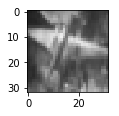

Target: 0, Predicted: 3


In [16]:
# Look at examples of misses
from imageutils import bgr2rgb
idx = misses[random.randint(0,len(misses))]
im = testX[idx]
plt.figure(figsize=(1.5,1.5))
plt.imshow(bgr2rgb(im))
plt.show()
print('Target: {0}, Predicted: {1}'.format(targets[idx], preds[idx]))


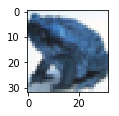

Target: 6, Predicted: 6


In [17]:
# Look at examples of hits
from imageutils import bgr2rgb
idx = hits[random.randint(0,len(hits))]
im = testX[idx]
plt.figure(figsize=(1.5,1.5))
plt.imshow(bgr2rgb(im))
plt.show()
print('Target: {0}, Predicted: {1}'.format(targets[idx], preds[idx]))